In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchinfo import summary

from models.deepLOB.deepLOB_model import Deeplob
from utils.preprocessing_v2 import create_windows, generate_labels, normalize_features, add_features
from utils.training import train_validate # train, validate
from utils.loader import LOBDataset
from utils.evaluation import evaluate
from utils.plots import plot_training_history, plot_label_distributions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

In [56]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 128 # 32
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_20'
LABEL_ALPHA = 5e-5 #1e-5

LEARNING_RATE = 1e-4
# ADAM_B1 = 0.9
# ADAM_B2 = 0.999
# WEIGHT_DECAY= 5e-5 # 1e-5

In [57]:
data_df = pd.read_csv(DATA_PATH, index_col=0)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030728 entries, 0 to 1030727
Columns: 155 entries, system_time to asks_market_notional_14
dtypes: float64(154), object(1)
memory usage: 1.2+ GB


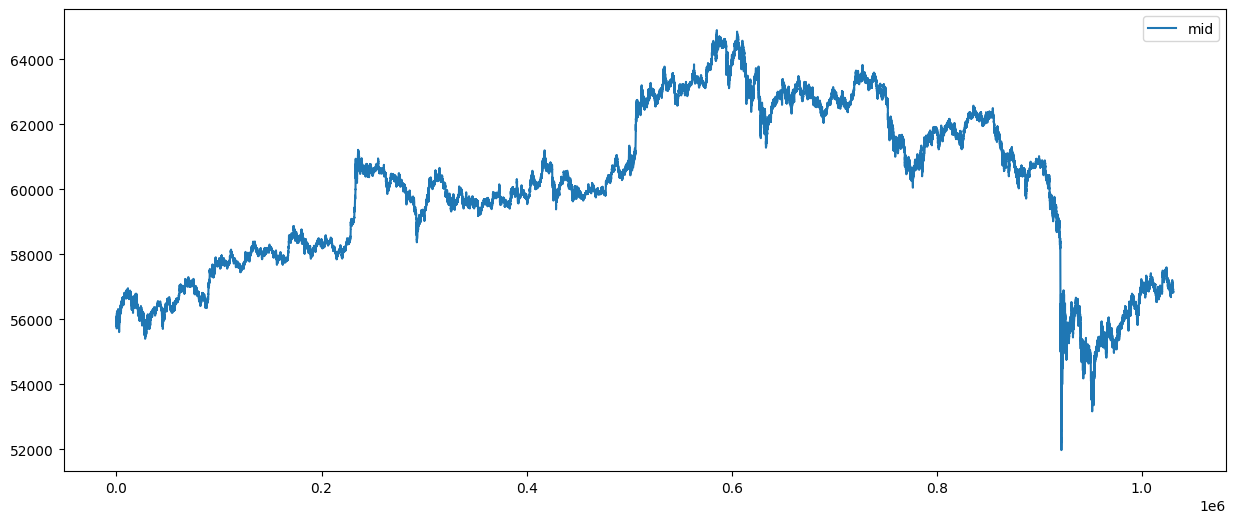

In [58]:
plt.figure(figsize=(15, 6))
plt.plot(data_df['midpoint'], label='mid')
plt.legend()
# plt.grid()
plt.show()

In [59]:
data_df = data_df[400000:700000]#.copy()
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
400000,2021-04-12 02:40:26.102749+00:00,59723.315,0.01,29.860466,30.732421,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400001,2021-04-12 02:40:27.102749+00:00,59723.315,0.01,1942.150407,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400002,2021-04-12 02:40:28.102749+00:00,59723.315,0.01,588.190492,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400003,2021-04-12 02:40:29.102749+00:00,59723.315,0.01,0.000000,8.039355,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000014,-0.000042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400004,2021-04-12 02:40:30.102749+00:00,59723.315,0.01,56.740140,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000014,-0.000042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,2021-04-15 14:01:27.175683+00:00,63038.295,0.01,1926.599251,1648.929389,-7.931686e-08,-5.004894e-05,-5.020757e-05,-0.000051,-0.000120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699996,2021-04-15 14:01:28.175683+00:00,63035.075,0.01,5143.262555,19881.770277,-7.932092e-08,-2.379628e-07,-3.973978e-05,-0.000069,-0.000089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699997,2021-04-15 14:01:29.175683+00:00,63035.075,0.01,406.862445,0.000000,-7.932092e-08,-2.379628e-07,-2.228918e-05,-0.000022,-0.000029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699998,2021-04-15 14:01:30.175683+00:00,63035.075,0.01,962.435991,4727.630250,-7.932092e-08,-2.379628e-07,-2.244782e-05,-0.000029,-0.000040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
cancel_notional_features = [f"{side}_cancel_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
limit_notional_features = [f"{side}_limit_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
market_notional_features = [f"{side}_market_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]

midpoint_delta_features = ['midpoint_delta']

In [61]:
data_df = data_df[meta_features + distance_features + notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=LABEL_ALPHA)
# data_df = add_features(data_df)
data_df = normalize_features(data_df)
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_5,asks_notional_6,asks_notional_7,asks_notional_8,asks_notional_9,y_10,y_20,y_30,y_50,y_100
400000,2021-04-12 02:40:26.102749+00:00,59723.315,0.01,29.860466,30.732421,0.597233,0.597233,0.597233,0.597208,0.597203,...,0.000166,0.005974,0.000920,0.000408,0.000268,1,0,1,0,2
400001,2021-04-12 02:40:27.102749+00:00,59723.315,0.01,1942.150407,0.000000,0.597233,0.597233,0.597233,0.597208,0.597208,...,0.000166,0.006340,0.000920,0.000408,0.000268,1,0,2,0,2
400002,2021-04-12 02:40:28.102749+00:00,59723.315,0.01,588.190492,0.000000,0.597233,0.597233,0.597233,0.597208,0.597197,...,0.000166,0.006340,0.000920,0.000408,0.000268,0,0,2,0,2
400003,2021-04-12 02:40:29.102749+00:00,59723.315,0.01,0.000000,8.039355,0.597233,0.597233,0.597233,0.597225,0.597208,...,0.000166,0.000920,0.000920,0.000408,0.000268,0,0,1,0,2
400004,2021-04-12 02:40:30.102749+00:00,59723.315,0.01,56.740140,0.000000,0.597233,0.597233,0.597233,0.597225,0.597208,...,0.000166,0.000920,0.000920,0.000408,0.000268,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,2021-04-15 14:01:27.175683+00:00,63038.295,0.01,1926.599251,1648.929389,0.630383,0.630351,0.630351,0.630351,0.630307,...,0.002254,0.081787,0.003153,0.000636,0.000400,1,1,1,1,1
699996,2021-04-15 14:01:28.175683+00:00,63035.075,0.01,5143.262555,19881.770277,0.630351,0.630351,0.630326,0.630307,0.630295,...,0.002254,0.018847,0.002843,0.078887,0.001166,1,1,1,1,1
699997,2021-04-15 14:01:29.175683+00:00,63035.075,0.01,406.862445,0.000000,0.630351,0.630351,0.630337,0.630337,0.630332,...,0.002841,0.078887,0.001166,0.003153,0.000636,1,1,1,1,1
699998,2021-04-15 14:01:30.175683+00:00,63035.075,0.01,962.435991,4727.630250,0.630351,0.630351,0.630337,0.630332,0.630326,...,0.002254,0.078887,0.020013,0.001166,0.009458,1,1,1,1,1


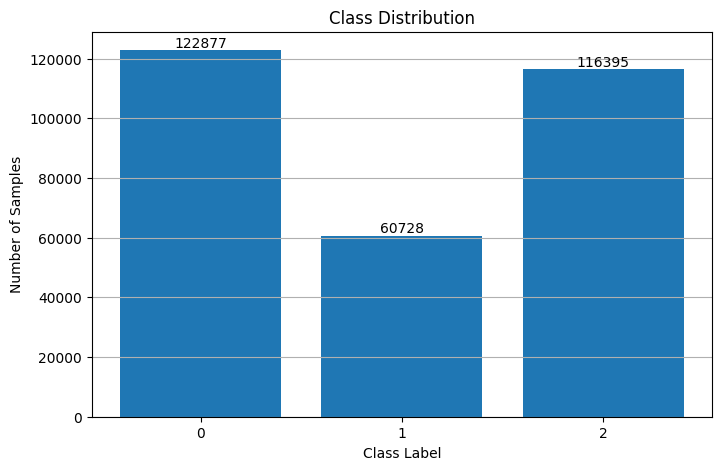

In [62]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

In [63]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((300000, 40), (300000,))

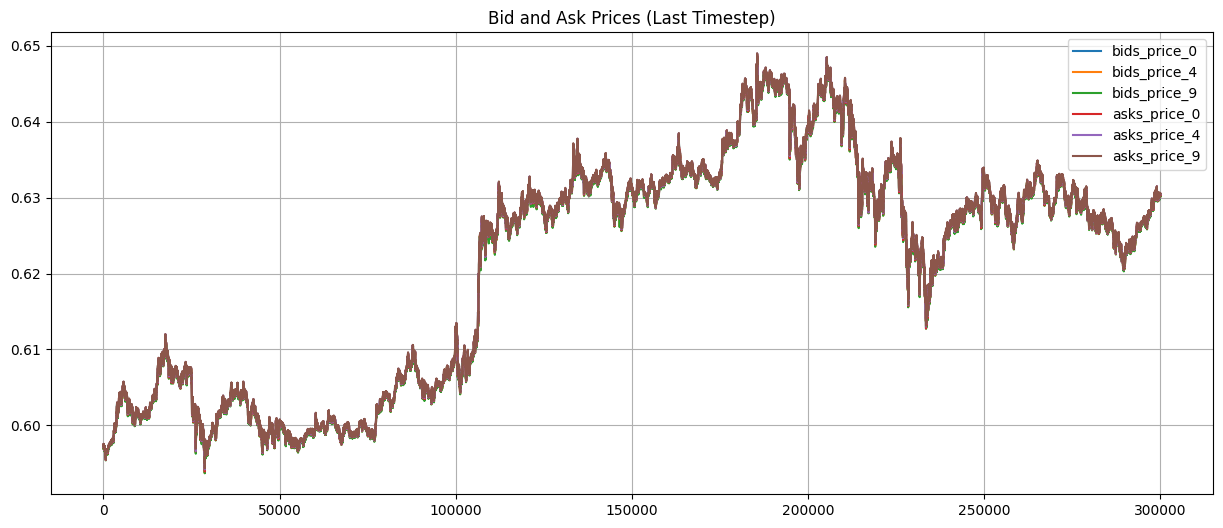

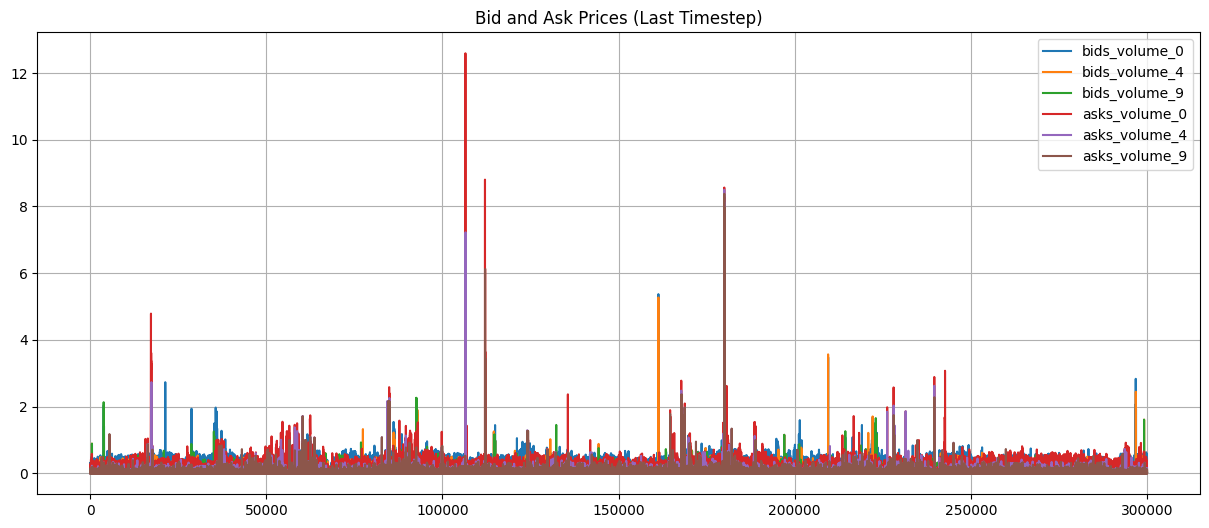

In [64]:
s = 0
l = len(X)

X_plot = X[s:s+l]  # or use `next(iter(train_loader))` for a batch
df_plot = pd.DataFrame(X_plot, columns=[f'feature_{i}' for i in range(X_plot.shape[1])])

price_levels = 10
features = []
for i in range(price_levels):
    features.append(f'bids_price_{i}')
for i in range(price_levels):
    features.append(f'asks_price_{i}')
for i in range(price_levels):
    features.append(f'bids_volume_{i}')
for i in range(price_levels):
    features.append(f'asks_volume_{i}')
    
df_plot.columns = features

bid_price_cols = ['bids_price_0', 'bids_price_4', 'bids_price_9']
ask_price_cols = ['asks_price_0', 'asks_price_4', 'asks_price_9']

plt.figure(figsize=(15, 6))
for col in bid_price_cols:
    plt.plot(df_plot[col].values, label=col)
for col in ask_price_cols:
    plt.plot(df_plot[col].values, label=col)
plt.title('Bid and Ask Prices (Last Timestep)')
plt.legend()
plt.grid()
plt.show()

bid_price_cols = ['bids_volume_0', 'bids_volume_4', 'bids_volume_9']
ask_price_cols = ['asks_volume_0', 'asks_volume_4', 'asks_volume_9']

plt.figure(figsize=(15, 6))
for col in bid_price_cols:
    plt.plot(df_plot[col].values, label=col)
for col in ask_price_cols:
    plt.plot(df_plot[col].values, label=col)
plt.title('Bid and Ask Prices (Last Timestep)')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(df_plot['feature_0'], label='feature_0 (bid_1_price)')
# # plt.plot(df_plot['feature_39'], label='feature_39 (ask_10_vol)')
# plt.legend()
# plt.title("LOB Features over Samples")
# plt.grid()
# plt.show()

In [65]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(299900, 100, 40)

In [66]:
train_size = int(0.7 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_val, y_val = X_windows[train_size:], y_labels[train_size:]

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, 
#     test_size=0.1, 
#     random_state=42, 
#     shuffle=True
# )

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
# print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (209930, 100, 40), (209930,)
Validation shape: (89970, 100, 40), (89970,)


In [67]:
train_dataset = LOBDataset(X_train, y_train, True)
val_dataset = LOBDataset(X_val, y_val, True)
# test_dataset = LOBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(next(iter(train_loader))[0].shape)

torch.Size([128, 1, 100, 40])


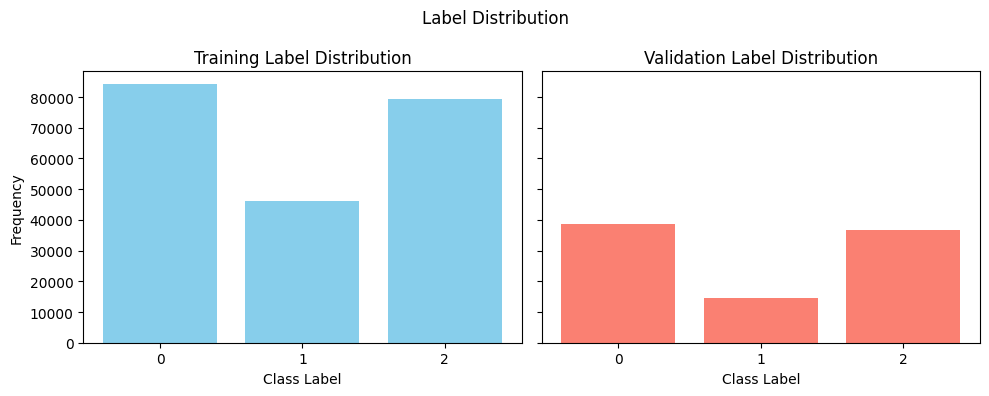

In [68]:
plot_label_distributions(train_dataset, val_dataset)

In [69]:
model_deepLOB = Deeplob().to(device)
summary(model_deepLOB, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
Deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [ ]:
epochs = 50
learning_rate = 1e-4

normalization="DecPre"
k=4
dataset_type="crypto"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=LEARNING_RATE)

history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

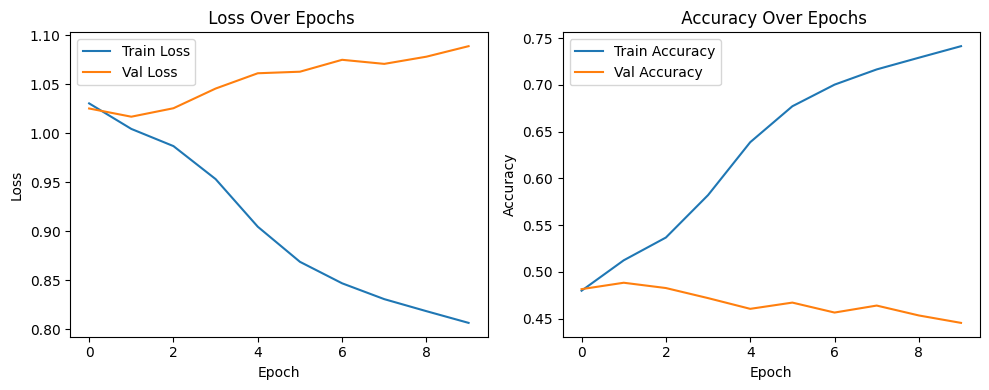

In [42]:
plot_training_history(history)

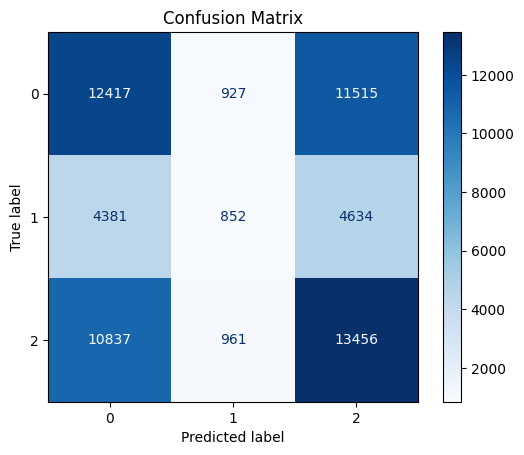

              precision    recall  f1-score   support

           0     0.4493    0.4995    0.4731     24859
           1     0.3109    0.0863    0.1352      9867
           2     0.4545    0.5328    0.4906     25254

    accuracy                         0.4456     59980
   macro avg     0.4049    0.3729    0.3663     59980
weighted avg     0.4287    0.4456    0.4249     59980

Test Accuracy: 0.4456
Test Precision (macro): 0.4049
Test Recall (macro): 0.3729
Test F1 Score (macro): 0.3663


In [43]:
evaluate(model_deepLOB, val_loader, device)